### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

### Data Description and visualization

Dataset consists of 801 input sample vectors, each vector has 20532 gene features.
Also the availbale classes are 5. The possible choises are PRAD, LUAD, BRCA, KIRC, COAD.
As we can see, we have class imbalance.

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78


We will use the "T-distributed stochastic neighbor embedding algorithm" to visualize
the high-dimensional data in a 2-D space.




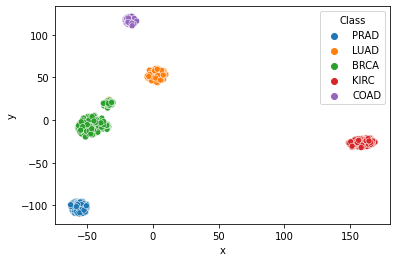

In [2]:
# Reading files and merging features with labels

dataset = pd.read_csv("Genes\data.csv")
labels = pd.read_csv("Genes\labels.csv")
dataset = pd.merge(dataset, labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

print(f'Dataset consists of {dataset.shape[0]} input sample vectors, each vector has {dataset.shape[1]} '\
      f'gene features.\nAlso the availbale classes are {len(dataset["Class"].unique())}.'\
      f' The possible choises are {", ".join(val for val in dataset.Class.unique())}.')
class_counts = dataset.Class.value_counts()
print(f'As we can see, we have class imbalance.\n\n{class_counts.to_string()}\n\n')

# T-distributed stochastic neighbor embedding algorithm for 2-D representation of 
# high-dimensioned data.

print(f'We will use the "T-distributed stochastic neighbor embedding algorithm" to visualize\n'\
      f'the high-dimensional data in a 2-D space.\n\n')
m = TSNE(init = 'pca', n_components = 2, learning_rate=20)
tsne_features = m.fit_transform(dataset.drop('Class', axis=1))


dataset.loc[:,'x'] = tsne_features[:,0]
dataset.loc[:,'y'] = tsne_features[:,1]
sns.scatterplot(x="x", y="y", hue='Class', data=dataset)
plt.savefig("TSNE_visualization_algorithm.png")
plt.show()
dataset.drop(['x', 'y'], axis=1, inplace=True)

### Preprocessing

In [3]:
# Encode the labels and updaate values

le = preprocessing.LabelEncoder()
dataset["Class"] = le.fit_transform(labels.drop("Unnamed: 0", axis=1).values.ravel())
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))

# Normalize tha features except tha labels

x = dataset.iloc[:, :-1].values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

print(f'We used Label encoding to work with numerical values instead of categorical.\n'\
      f'The labels now are: {dictionary}.\nAlso each column has been normalized ans scaled.')

We used Label encoding to work with numerical values instead of categorical.
The labels now are: {'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}.
Also each column has been normalized ans scaled.


### Applying Principal Component Analysis for dimensionality reduction

In [4]:
# Create PCA object to keep 95% of variance
pca = PCA(0.95)

# Apply PCA in input vector
pca.fit(dataset.iloc[:,:-1])

# Save results in an np.array
reduced = pca.transform(dataset.iloc[:,:-1])

#Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
decomposed = pd.DataFrame(np.column_stack((reduced, x)))

print(f'After applying PCA to the dataset, we end up with {decomposed.shape[1]} features \n'\
      f'instead of the original {dataset.shape[1]}.')

#Rename columns
for column in decomposed.columns:
    if column<len(decomposed.columns)-1:
        decomposed.rename(columns={column : f"PCA{column+1}"}, inplace=True)
    else:
        decomposed.rename(columns={column : "Label"}, inplace=True)


After applying PCA to the dataset, we end up with 511 features 
instead of the original 20532.


### Further dimensionality reduction

Still, there are many features, but with no significance at all. So components with more than 0.1% variance
and cummulative variance sum of all appended components to be as close to 75%.



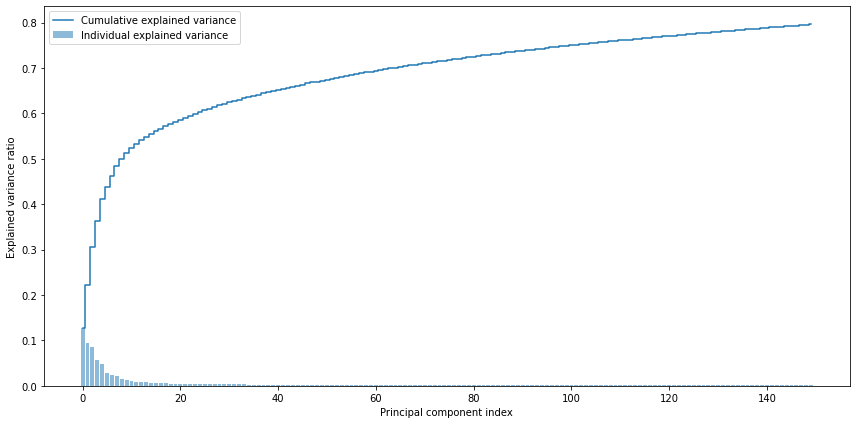


After further elimination of features we end up with the final form of the data.

        PCA1       PCA2       PCA3      PCA4      PCA5      PCA6      PCA7  \
0  -5.668141  -8.872139  15.853290 -6.659908  3.244882  3.529868 -0.186630   
1  -1.470204  10.280182  -1.246634 -1.597277 -5.053639  5.329966 -3.213423   
2 -10.845387  -1.345352   4.000770  8.010467  3.520304  6.439937 -2.008366   
3  -9.167961  -8.670123   5.481483  5.505311 -0.453232  4.098163 -2.687572   
4  -6.271848  -3.101208  -7.338976  0.433540  4.290824 -0.316748 -0.306964   

       PCA8      PCA9     PCA10  ...     PCA93     PCA94     PCA95     PCA96  \
0 -4.599118 -0.780447  1.000318  ... -0.192196 -0.091763  0.377116 -0.012125   
1  0.646405 -0.092015 -5.155488  ... -0.945464  0.272916 -0.660396  0.238561   
2  7.852581 -0.221889 -4.103816  ...  0.781941 -0.789400 -2.298390  0.443170   
3  2.294694 -0.065617 -2.497998  ... -0.887737  0.040757  1.105573 -0.350252   
4 -1.433246 -3.194915  4.058295  ... -0.027539 -

In [5]:
print(f'Still, there are many features, but with no significance at all. So components with more than 0.1% variance\n' \
      f'and cummulative variance sum of all appended components to be as close to 75%.\n')
 
#Calculating variance ration of each component and cummulative sum.  
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot with regards of components
plt.figure(figsize=(12, 6))
plt.bar(range(0,len(exp_var_pca[:150])), exp_var_pca[:150], alpha=0.5, 
        align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[:150])), cum_sum_eigenvalues[0:150], 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Explained_variance_VS_Cumulative_sum.png")
plt.show()

#Picking components with value bigger than 0.1% and overall variance as close to 75%
relevant_pca = {}
mask = []
s = 0;
for idx, val in enumerate(exp_var_pca):
    s += val
    if (val > 0.001 and s<=0.75):
        relevant_pca[f"PCA_{idx}"] = val
        mask.append(f"PCA{idx+1}")
    else:
        break
mask.append('Label')

#Final dataset after feature extraction and further process
final_df = decomposed[mask]

print(f'\nAfter further elimination of features we end up with the final form of the data.\n\n{final_df.head()}')

### Model Implementation: Decision Tree

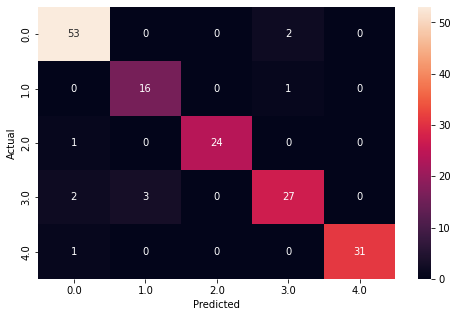

Accuracy:0.937888198757764


More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95        55
         1.0       0.84      0.94      0.89        17
         2.0       1.00      0.96      0.98        25
         3.0       0.90      0.84      0.87        32
         4.0       1.00      0.97      0.98        32

    accuracy                           0.94       161
   macro avg       0.93      0.94      0.93       161
weighted avg       0.94      0.94      0.94       161


Area Under Curve score: 0.9590875018282873


In [6]:
#Splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:,:-1],
                                                    final_df.Label, test_size=0.2, random_state=1)

#Creating model and predicting output values on testing data.
DT = DecisionTreeClassifier(criterion='entropy')
DT = DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)


#Confusion matrix
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.savefig("Confusion_Matrix_DT.png")
plt.show()

print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}\n\n")
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}\n')
roc_dt = metrics.roc_auc_score(y_test, DT.predict_proba(X_test), average = 'weighted', multi_class='ovr')
print(f'Area Under Curve score: {roc_dt}')

### Decision Tree layout

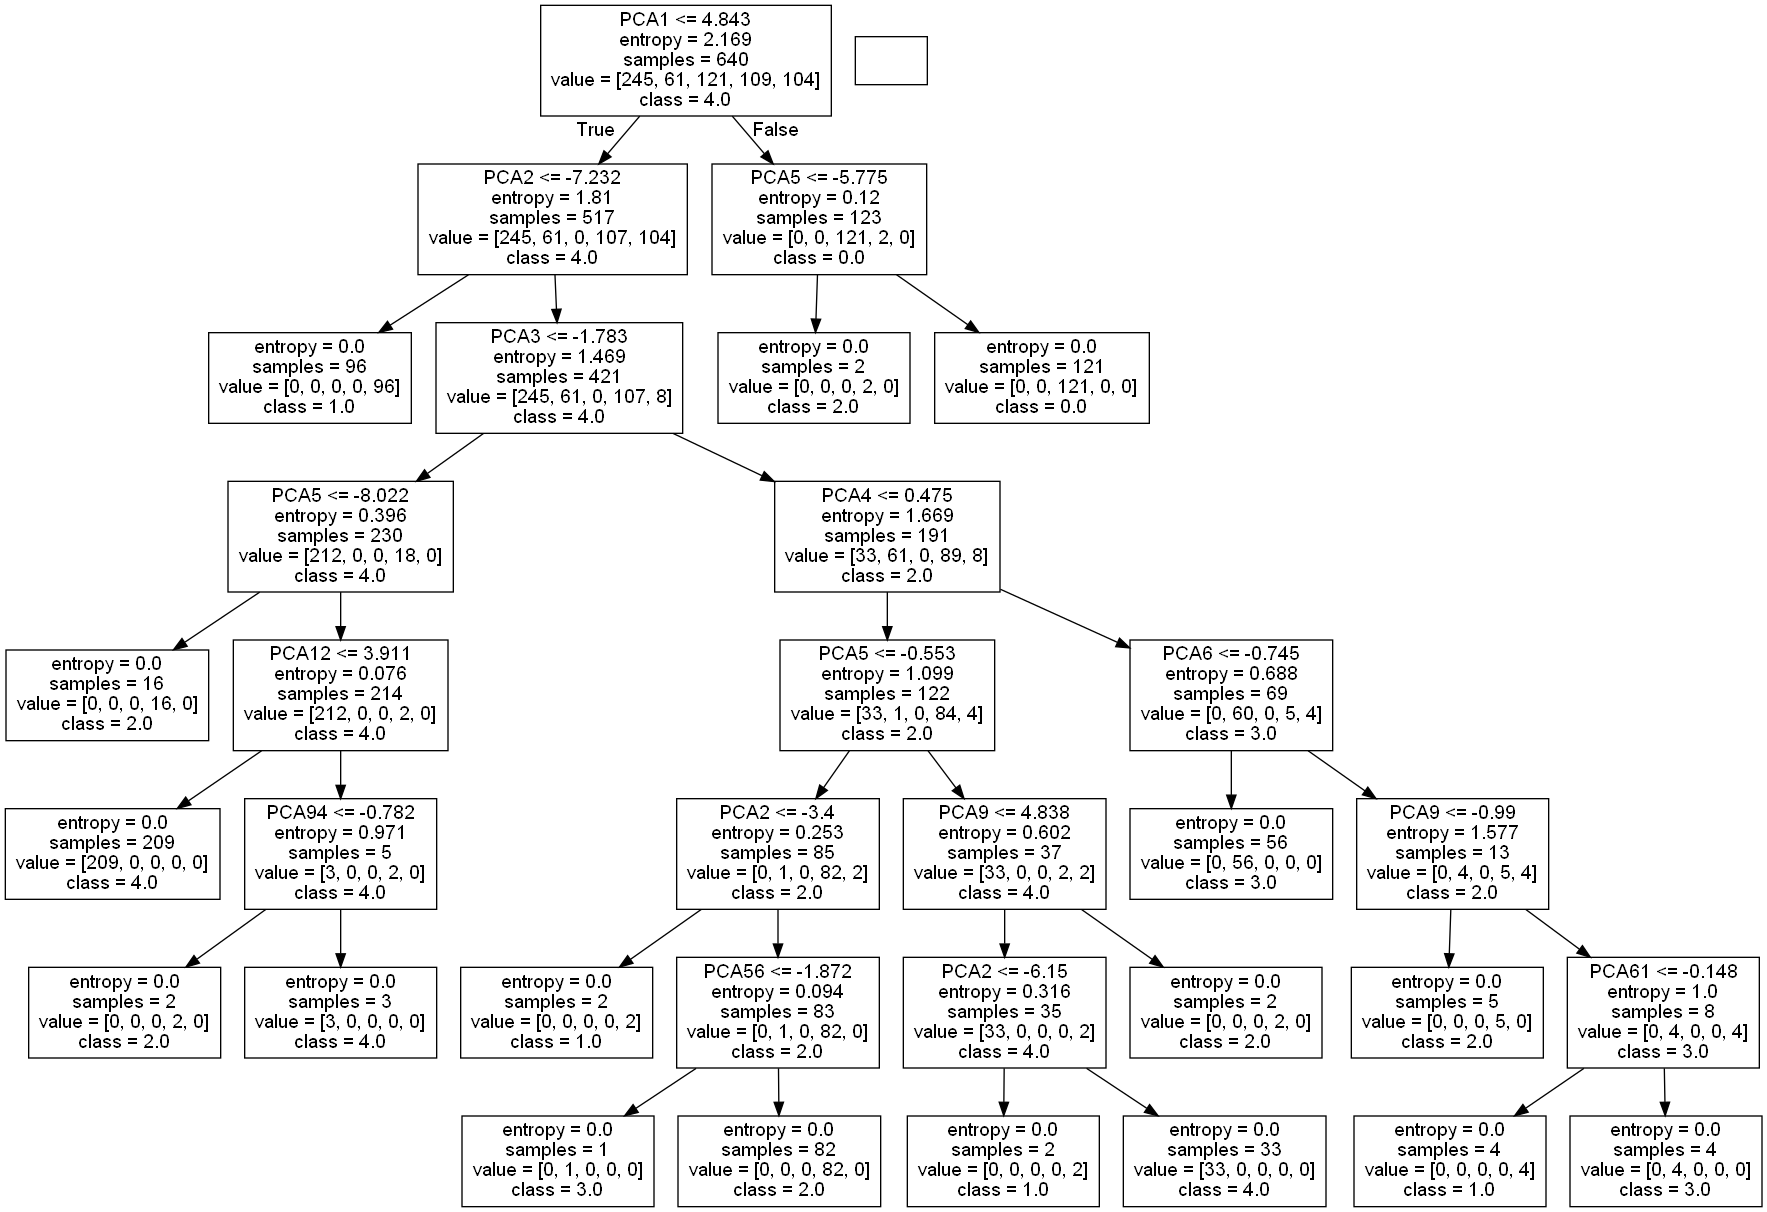

In [7]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from graphviz import Source

dt = StringIO()
export_graphviz(DT, out_file=dt, feature_names = final_df.columns[:-1], 
                class_names=final_df.Label.unique().astype(str))
graph = pydotplus.graph_from_dot_data(dt.getvalue()) 
graph.write_png("Decision_Tree_layout.png")
Image(graph.create_png())


### KNN implementation 

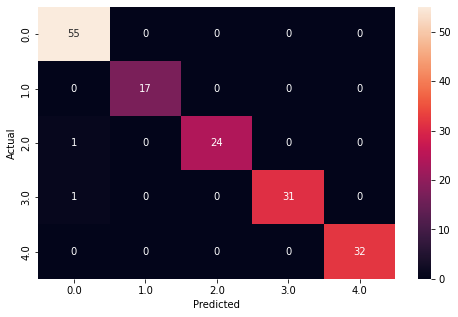

Accuracy:0.9875776397515528


More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        55
         1.0       1.00      1.00      1.00        17
         2.0       1.00      0.96      0.98        25
         3.0       1.00      0.97      0.98        32
         4.0       1.00      1.00      1.00        32

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



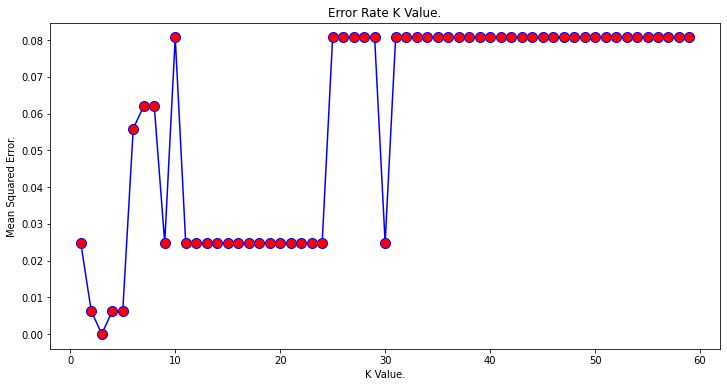

In [8]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

#Confusion matrix
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}\n\n")

print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    squared_error = np.power(y_test - preds,2)
    error.append(np.mean(squared_error))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), error, color='blue', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate K Value.')
plt.xlabel('K Value.')
plt.ylabel('Mean Squared Error.')
plt.savefig("KNN_error_over_multiple_neighbors.png")

### K-Fold function

In [9]:
def k_fold(folds):
    split_data = KFold(n_splits = folds, shuffle = True, random_state = 100)
    return split_data, folds

In [10]:
dt_k, dt_folds = k_fold(3)
dt_k_, dt_folds_ = k_fold(5)
input_data = final_df.iloc[:,:-1]
label_data = final_df.iloc[:,-1]
result = cross_val_score(DT , input_data, label_data, cv = dt_k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")
result_ = cross_val_score(DT , input_data, label_data, cv = dt_k_)
print(f"Average accuracy from 5 folds: {result_.mean()}")


Average accuracy from 3 folds: 0.9538077403245943

Average accuracy from 5 folds: 0.9588121118012423


In [79]:
k,f = k_fold(3)
result = cross_val_score(model , input_data, label_data, cv = k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")

Average accuracy from 3 folds: 0.951310861423221



### Grid search Function

In [11]:
def grid_search(model, hyper_params, score, folds):
    gs = GridSearchCV(estimator = model,
    param_grid = hyper_params,
    scoring = score,
    cv = folds,
    verbose = 1,
    return_train_score = True)
    return gs    

In [76]:
#Search for optimal Decision Tree parameters
dt_hp = [{'criterion': ['gini', 'entropy'],
       'splitter': ['best', 'random'],
       'max_depth': [3,4,5,6,7,None]}]

model_gs_ = grid_search(DT, dt_hp, 'accuracy', dt_k_)
model_gs_.fit(input_data, label_data)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 4, 5, 6, 7, None],
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [77]:
print(f"Model best parameter with {dt_folds_} folds are: {model_gs_.best_params_}")

Model best parameter with 5 folds are: {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}


In [105]:
DT_best_ = DecisionTreeClassifier(criterion='entropy', splitter ='best', max_depth = 7)
DT_best_ = DT_best_.fit(X_train,y_train)
y_pred_ = DT_best_.predict(X_test)
print(f'Decision tree accuracy score with {dt_folds_} and optimal parameters: {metrics.accuracy_score(y_test, y_pred_)}')

Decision tree accuracy score with 5 and optimal parameters: 0.9503105590062112


### Model Implementation: Random Forest

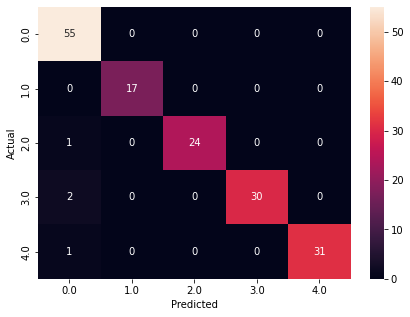

Accuracy:0.9751552795031055


More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        55
         1.0       1.00      1.00      1.00        17
         2.0       1.00      0.96      0.98        25
         3.0       1.00      0.94      0.97        32
         4.0       1.00      0.97      0.98        32

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161

Area Under Curve score: 0.9590875018282873


In [114]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)
plt.figure(figsize=(7, 5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.savefig("Confusion_matrix_RF")
plt.show()
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}\n\n")
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')
roc = metrics.roc_auc_score(y_test, DT.predict_proba(X_test), average = 'weighted', multi_class='ovr')
print(f'Area Under Curve score: {roc}')

In [137]:
rf_k, rf_folds = k_fold(3)
rf_k_, rf_folds_ = k_fold(5)
result = cross_val_score(RF , input_data, label_data, cv = rf_k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")
result_ = cross_val_score(RF , input_data, label_data, cv = rf_k_)
print(f"Average accuracy from 5 folds: {result_.mean()}")

Average accuracy from 3 folds: 0.9812734082397002

Average accuracy from 5 folds: 0.9812888198757765


In [125]:
rf_hp = [{'n_estimators': range(100,501,100),
          'criterion': ['entropy'],
          'max_features':['auto'],
          'max_depth': [5,6,7,None],
          'max_leaf_nodes': [None,1,2],
          'n_jobs': [8],
          'random_state': [None, 1]}]

model_gs_ = grid_search(RF, rf_hp, 'accuracy', rf_k_)
model_gs_.fit(input_data, label_data)
print(f"Model best parameter with {rf_folds_} folds are: {model_gs_.best_params_}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Model best parameter with 5 folds are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 500, 'n_jobs': 8, 'random_state': 1}
